# Objective

- Determine the coefficients of a linear predictor
- Compare to theoretical solution
- Show prediction error on an example

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

matplotlib.rc('figure', figsize=(18, 6) )

# Define Parameters and Filter Impulse Response

In [13]:
# sampling time and Nyquist frequency 
t_s = 1.
f_Nyquist = 1 / (2.0 * t_s )

In [14]:
### choose filter

switch = 1


if switch == 1:
    ### Filter from scipy

    cutoff_freq = f_Nyquist / 3

    ripple_db = 30                     # ripples and transition width of the filter
    width = f_Nyquist / 20.0
    print(width)
    N, beta = signal.kaiserord( ripple_db, width )    # find filter order and beta parameter

    # find filter and filter input
    h = signal.firwin( N, cutoff=cutoff_freq,  window=('kaiser', beta), nyq = f_Nyquist)


elif switch == 2:
    ### RC

    N = 65
    n_sps = 4
    time_vector = np.arange( -N//2, N//2 )
    beta_rc = 0.25

    h = np.sin( np.pi * ( time_vector / n_sps ) ) / (np.pi * ( time_vector / n_sps ) ) * \
                np.cos( np.pi * beta_rc * ( time_vector / n_sps  ) ) / ( 1 - ( 2 * beta_rc * ( time_vector / n_sps ) )**2 )
    h[ np.isnan( h ) ] = 1
    h[ np.isinf( h ) ] = 0


elif switch == 3:
    ### simple moving average

    N = 25
    h = np.ones( N )


elif switch == 4:
    ### random impulse respone

    N = 25
    h = np.zeros( N ) 

    lin = np.arange( 0, (N-1)/2)
    h[ : (N-1)//2 ] = lin
    h[ (N-1)//2 ] = (N-1)//2
    h[ (N-1)//2 +1 : ] = lin[ ::-1 ]
    h /= ( (N-1)//2 )


elif switch == 5:
    ### random impulse respone

    N = 15
    h = 10 * np.random.rand( N )

H = np.fft.fft( np.append( h, np.zeros( 9*len( h ) ) ) )
f_vector = np.linspace( -.5, .5, len( H ) )


0.025


/tmp/ipykernel_174796/1949770632.py:17: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  h = signal.firwin( N, cutoff=cutoff_freq,  window=('kaiser', beta), nyq = f_Nyquist)


### Plotting

Text(0, 0.5, '$|H[k]|^2$')

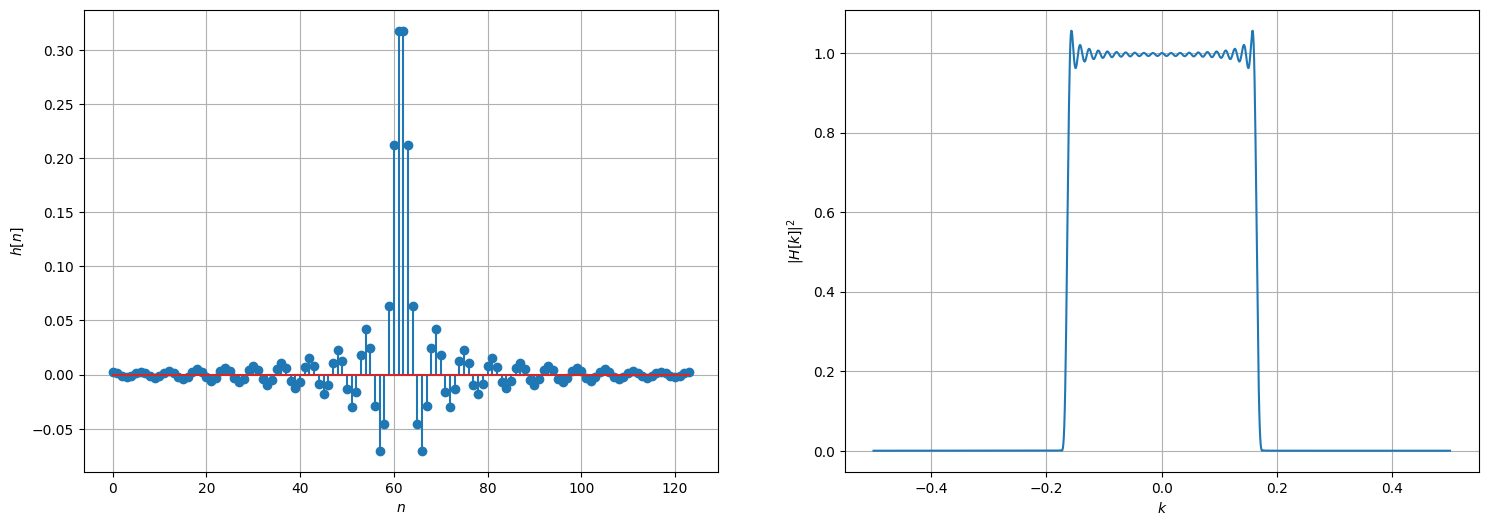

In [15]:
plt.subplot(121)
plt.stem( h )
plt.grid( True )
plt.xlabel('$n$')
plt.ylabel( '$h[n]$')

plt.subplot(122)
plt.plot( f_vector, np.abs( np.fft.fftshift( H ) )**2 )
plt.grid( True )
plt.xlabel('$k$')
plt.ylabel( '$|H[k]|^2$')

# Determine Prediction Coefficients

- First, a noisy observation of the according signal is generated
- Afterwards, auto-correlation function is estimated and used for solving the Wiener-Hopf equation

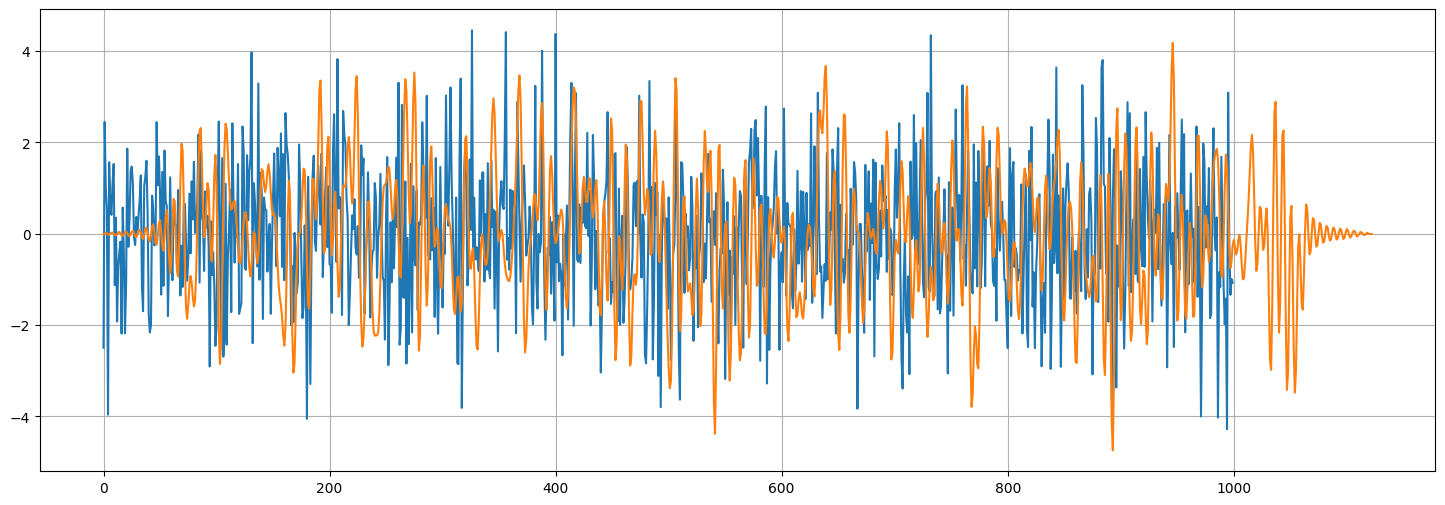

In [16]:
# length of signal to be generated
N_signal = int( 1e3 )

# generate noise at random and apply filter
# filter is normalized to have unit energy
x = np.sqrt( 2 ) * np.random.randn( N_signal )

h /= np.linalg.norm(h)
x_filtered = np.convolve( x, h)

plt.plot(x)
plt.plot(x_filtered)
plt.grid(True)

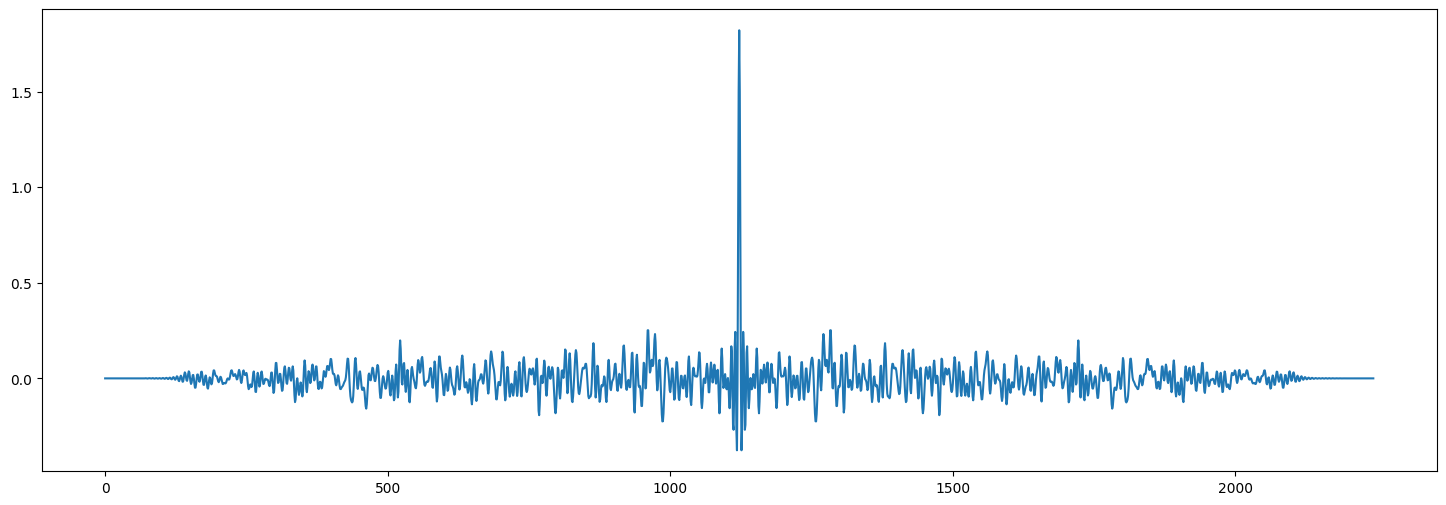

In [17]:
acf = 1/len(x_filtered) * np.correlate( x_filtered, x_filtered, 'full' )
plt.plot( acf )

In [18]:
# length of prediction filter
N_predict = len(h)

In [19]:
acf_lags_geq_0 = acf[ len(acf)//2 : ]

#extracting relevant parameters with notation as used in the lecture
r = acf_lags_geq_0[ 1 : N_predict + 1]

# construct acf matrix of corresponding dimension
R = np.zeros( ( N_predict, N_predict ) )
for _n in range( N_predict ):
    R[ _n, : ] = acf[ len(acf)//2 - _n : len(acf)//2 - _n + N_predict ]

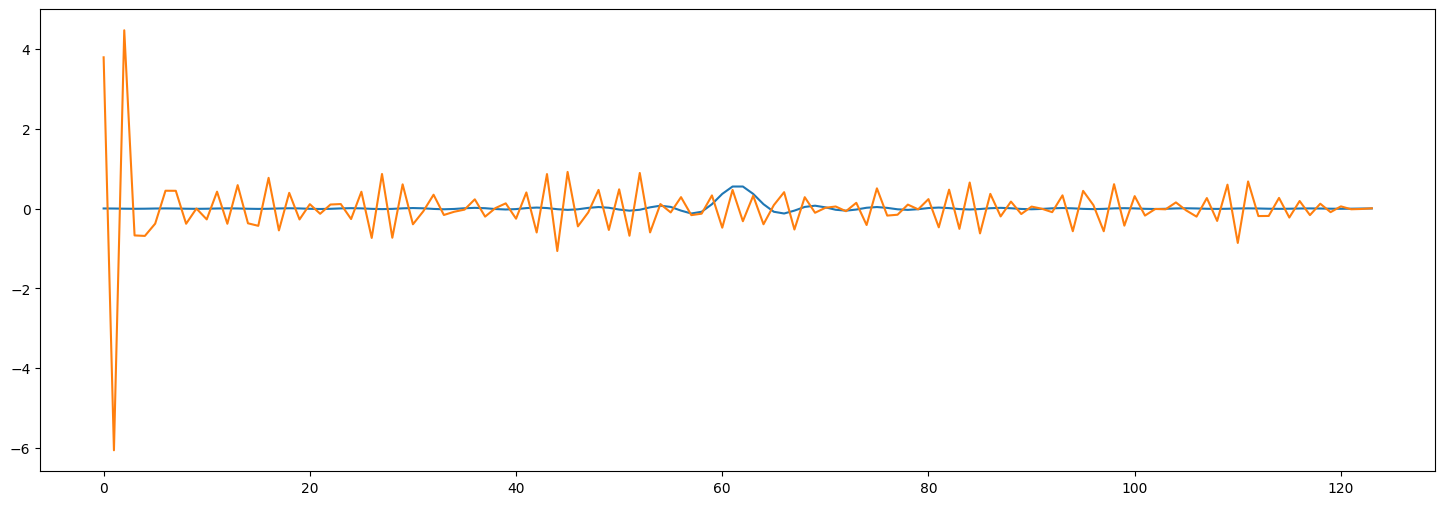

In [20]:
# solve Wiener-Hopf equation
p = np.matmul( np.linalg.inv( R ), r ) 

plt.plot(h)
plt.plot(p)

In [21]:
# predict signal and compare to actual signal
x_predicted = np.zeros( len( x_filtered ) )
x_predicted[ : N_predict ] = x_filtered[ : N_predict ]

for _n in range( N_predict, len(x_predicted) ):
    x_predicted[ _n ] = np.correlate( x_predicted[ _n - N_predict : _n ], p[::-1] ) 

Text(0.5, 0, '$\\alpha$')

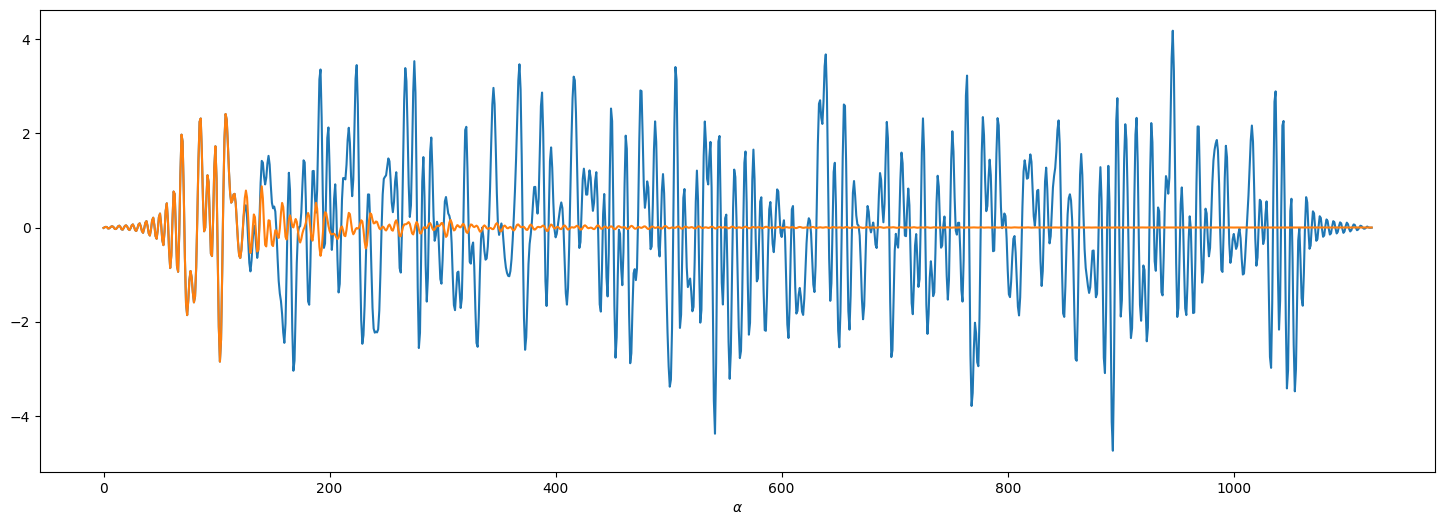

In [22]:
plt.plot(x_filtered)
plt.plot(x_predicted)
plt.xlabel('$\\alpha$')